In [20]:
from markethistory import MarketHistory
from constants import * 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
from supervised import *
import pandas as pd
import json
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
with open('config.json') as file:
    config = json.load(file)

Example

In [26]:
markethistory = MarketHistory(config)

In [27]:
markethistory.data.shape

(6, 11, 66330)

In [28]:
data = data_maker(markethistory.data,lookback_window=15,normalization="returns")

/Users/Nathan/Desktop/cs194/project/cryptoprofit/deepm/supervised.py:99: RuntimeWarning: divide by zero encountered in true_divide
  returns = np.diff(prices,axis=1) / prices[:,:-1]
/Users/Nathan/Desktop/cs194/project/cryptoprofit/deepm/supervised.py:99: RuntimeWarning: invalid value encountered in true_divide
  returns = np.diff(prices,axis=1) / prices[:,:-1]


In [31]:
agent = Agent(data,markethistory.traded_coins,num_rounds=10)

Training coin: BCH
Training error
0.407
Validation error
0.416
Training coin: DGB
Training error
0.396
Validation error
0.379
Training coin: ETC
Training error
0.395
Validation error
0.437
Training coin: ETH
Training error
0.413
Validation error
0.433
Training coin: LTC
Training error
0.42
Validation error
0.437
Training coin: SC
Training error
0.373
Validation error
0.386
Training coin: STR
Training error
0.426
Validation error
0.423
Training coin: XEM
Training error
0.416
Validation error
0.441
Training coin: XMR
Training error
0.402
Validation error
0.425
Training coin: XRP
Training error
0.428
Validation error
0.45
Training coin: reversed_USDT
Training error
0.438
Validation error
0.472


In [ ]:
mode

In [33]:
pd.Series(agent.models['SC'].bst.feature_importances_,
          index=['Close','High','Low','Volume','MA Short','MA Long']).sort_values(ascending=True).plot(kind='barh',figsize=(12,18),title='XGBOOST FEATURE IMPORTANCE')

AttributeError: 'Booster' object has no attribute 'feature_importances_'

In [38]:

agent.models['SC'].bst

AttributeError: 'Booster' object has no attribute 'plot'

### Classification (before we modularized everything and added moving average features)

In [157]:
len_window = 3000
prices_trading = data_[0,:,T-len_window:]
returns = np.diff(prices_trading,axis=1)
ret = (returns / prices_trading[:,:-1]).T

#### One model for each coin

In [160]:
len_window = 10000
prices_trading = data_[0,:,T-len_window:T]
returns = np.diff(prices_trading,axis=1)
ret = (returns / prices_trading[:,:-1]).T
lookback = 20
n = len_window - 1
split_index = int(.8*n)
regression = False
use_prices = False
X_train = {}
Y_train = {}
for coin in range(11):
    x_train = []
    y_train = []
    for i in range(lookback,split_index):
        if use_prices is True:
            x = np.append(data_[0,coin,i-lookback:i].reshape(-1,),i)
        else:
            x = np.append(ret[i-lookback:i,coin].reshape(-1,),i)
        x_train.append(x)
        y = ret[i,coin]
        if regression is False:
            if y > 0:
                y = 1
            else:
                y = 0
        y_train.append(y)
    X_train[coin] = x_train
    Y_train[coin] = y_train

X_test = {}
Y_test = {}
for coin in range(11):
    x_test = []
    y_test = []
    for i in range(split_index,n):
        if use_prices is True:
            x = np.append(data_[0,coin,i-lookback:i].reshape(-1,),i)
        else:
            x = np.append(ret[i-lookback:i,coin].reshape(-1,),i)
        x_test.append(x)
        y = ret[i,coin]
        if regression is False:
            if y > 0:
                y = 1
            else:
                y = 0
        y_test.append(y)
    X_test[coin] = x_test
    Y_test[coin] = y_test

In [203]:
preds = {}
for i in range(11):
    x_train = X_train[i]
    y_train = Y_train[i]
    x_test = X_test[i]
    y_test = Y_test[i]
    dtrain = xgb.DMatrix(np.array(x_train),label=np.array(y_train))
    if regression is True:
        obj = "reg:linear"
    else:
        obj = "binary:logistic"
    param = {'max_depth':5, 'eta':.5, 'silent':0,'alpha':1,'min_child_weight':5, 'objective':obj }
    num_round = 10
    bst = xgb.train(param, dtrain, num_round)
    print(i)
    print("train error")
    print(bst.eval(dtrain))
    print("test error")
    dtest = xgb.DMatrix(np.array(x_test),label=np.array(y_test))
    print(bst.eval(dtest))
    preds[i] = bst.predict(xgb.DMatrix(np.array(x_test)))

0
train error
[0]	eval-error:0.330994
test error
[0]	eval-error:0.493500
1
train error
[0]	eval-error:0.302294
test error
[0]	eval-error:0.401500
2
train error
[0]	eval-error:0.333751
test error
[0]	eval-error:0.488500
3
train error
[0]	eval-error:0.325605
test error
[0]	eval-error:0.491500
4
train error
[0]	eval-error:0.319213
test error
[0]	eval-error:0.489500
5
train error
[0]	eval-error:0.279484
test error
[0]	eval-error:0.337500
6
train error
[0]	eval-error:0.312696
test error
[0]	eval-error:0.476000
7
train error
[0]	eval-error:0.342775
test error
[0]	eval-error:0.455500
8
train error
[0]	eval-error:0.315829
test error
[0]	eval-error:0.477500
9
train error
[0]	eval-error:0.331871
test error
[0]	eval-error:0.478500
10
train error
[0]	eval-error:0.325103
test error
[0]	eval-error:0.471500


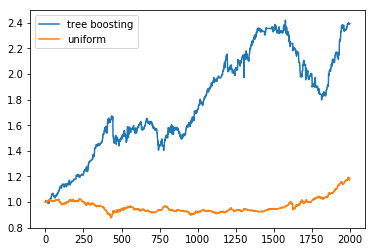

In [247]:
port = [1]
baseline = [1]
trading_coins = [5]
threshold_short = .2
threshold_long = .0
returns_boosting = []
returns_unif = []
status = ["" for i in range(11)]
for i in range(len(preds[0])):
    r = 0
    rb = 0
    for coin in range(11):
        rb += ret[split_index+i,coin] / 11
        if coin in trading_coins:
            if preds[coin][i] > 0.5 + threshold_long:
                if status[coin] == 'long':
                    fee = 0
                else:
                    fee = .0025
                r += (ret[split_index+i,coin] - fee )/ len(trading_coins) 
                status[coin] = 'long'
            elif preds[coin][i] <  0.5 - threshold_short:
                if status[coin] == "short":
                    fee = 0
                else:
                    fee = .0025
                r += (-ret[split_index+i,coin] - fee) / len(trading_coins) 
                status[coin] = 'short'
    returns_unif.append(rb)
    returns_boosting.append(r)
    val = port[-1] * (1+r)
    valb = baseline[-1]*(1+rb)
    port.append(val)
    baseline.append(valb)
plt.plot(port,label="tree boosting")
plt.plot(baseline,label="uniform")
plt.legend()

In [187]:
np.mean(returns_unif)/np.std(returns_unif)

0.029683821394980308

In [227]:
np.mean(returns_boosting)/np.std(returns_boosting)

0.11364366793134462